In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection
from collections import Counter
import torch
import seaborn as sns

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        defs = params.random_walk_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

FIGPATH = params.figPath / 'figS11-RW'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


### Get data

In [2]:
### Get data
def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_exec_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))

        #separate into reaches
        df_ = defs.get_reaches_df(df_)
        df_['reach_id'] = range(len(df_))

        #subset center-out trials
        df_ = df_[df_.center_dist < defs.subset_radius]
        df_ = df_.reset_index()

        #execution epoch
        for col in df_.columns:  #TODO: placeholder to prevent bug in pyaldata
            if 'unit_guide' in col:
                df_ = df_.drop([col], axis = 1)
        df_ = pyal.add_movement_onset(df_)
        allDFs_MCx.append(df_)

        df_ = pyal.restrict_to_interval(df_, epoch_fun=defs.exec_epoch)
        allDFs_exec_MCx.append(df_)
    
        
    return full_list_MCx, allDFs_MCx, allDFs_exec_MCx

def get_paired_dfs(MCx_list, allDFs_MCx, allDFs_exec_MCx):

    ref_file = 'Chewie_RT_CS_2016-10-21.mat' #TODO: put in defs
    ref_i = [y for x,y in MCx_list].index(ref_file)
    df1 = allDFs_exec_MCx[ref_i]

    Mihili_files = GoodDataList['MCx']['Mihili']
    MrT_files = GoodDataList['MCx']['MrT']
    comparison_files = Mihili_files + MrT_files

    paired_dfs = []
    for ex_file in comparison_files:
        
        ex_i = [y for x,y in MCx_list].index(ex_file)
        df2 = allDFs_exec_MCx[ex_i]

        #subset dataframes with matched reaches
        df1_idx, df2_idx = defs.get_matched_reaches_idx(df1, df2)
        df1_subset = df1.iloc[df1_idx]
        df2_subset = df2.iloc[df2_idx]

        #get dataframes from whole-trial data
        df1_ = pd.DataFrame({'reach_id':df1_subset.reach_id}).merge(allDFs_MCx[ref_i])
        df2_ = pd.DataFrame({'reach_id':df2_subset.reach_id}).merge(allDFs_MCx[ex_i])

        #set target ids
        # print(ex_file, len(df1_) - (df1_.target_group.values == df2_.target_group.values).sum(), 'diff target groups')
        df1_.target_group = df2_.target_group.values 
        df1_['target_id'] = df1_.target_group.values
        df2_['target_id'] = df2_.target_group.values

        #only keep target groups with enough trials
        counter = Counter(df1_.target_group)
        subset_target_groups = [k for k, c in counter.items() if c >= defs.min_trials_per_target]
        df1_ = df1_[df1_.target_group.isin(subset_target_groups)]
        df2_ = df2_[df2_.target_group.isin(subset_target_groups)]
        
        # print(len(subset_target_groups), 'target groups left')

        paired_dfs.append((ex_file, df1_, df2_))
    
    return paired_dfs

In [3]:
MCx_list, allDFs_MCx, allDFs_exec_MCx = get_full_random_walk_data()
paired_dfs = get_paired_dfs(MCx_list, allDFs_MCx, allDFs_exec_MCx)
# print(f'{len(paired_dfs)=}')

#example/ref session
ex_file = defs.ex_file
ref_file = defs.ref_file

#paired
ex_file_idx = [file for file,x,y in paired_dfs].index(ex_file)
print(ex_file_idx, ex_file)

# #unpaired
# i = [y for x,y in MCx_list].index(ex_file)
# print('ex', i, ex_file)
# ex_reaches_df = allDFs_exec_MCx[i]

# i = [y for x,y in MCx_list].index(ref_file)
# print('ref', i , ref_file)
# ref_reaches_df = allDFs_exec_MCx[i]

Mihili_RT_VR_2014-01-14.mat 137 diff target groups
28 target groups left
Mihili_RT_VR_2014-01-15.mat 147 diff target groups
28 target groups left
Mihili_RT_FF_2014-02-14.mat 129 diff target groups
26 target groups left
Mihili_RT_FF_2014-02-24.mat 123 diff target groups
20 target groups left
Mihili_RT_FF_2014-02-21.mat 131 diff target groups
22 target groups left
Mihili_RT_VR_2014-01-16.mat 124 diff target groups
21 target groups left
MrT_RT_FF_2013-08-22.mat 152 diff target groups
29 target groups left
MrT_RT_FF_2013-08-30.mat 123 diff target groups
16 target groups left
MrT_RT_VR_2013-09-10.mat 135 diff target groups
28 target groups left
MrT_RT_FF_2013-08-20.mat 97 diff target groups
14 target groups left
0 Mihili_RT_VR_2014-01-14.mat


### Fig 3A: Rasters

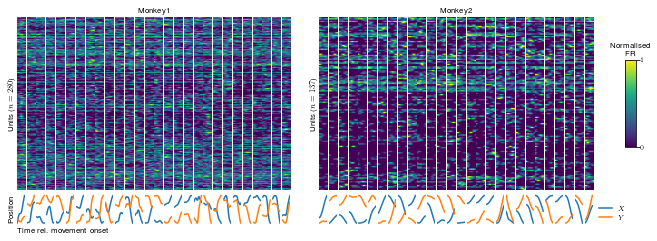

In [6]:
_, df1, df2 = paired_dfs[ex_file_idx]

fig = plt.figure(figsize=(10,6))
gs1   =fig.add_gridspec(nrows=1, ncols=len(np.unique(df1.target_id)), left=0.1, bottom=0.4, right=.48, top=.8)
gs2   =fig.add_gridspec(nrows=1, ncols=len(np.unique(df2.target_id)), left=.52, bottom=0.4, right=.9, top=.8)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.945, bottom=0.5, right=.96, top=.7)
cax = fig.add_subplot(gs_c[:])

trial=2

for i,df in enumerate([df1,df2]):
    df2 = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    data = []
    axes = []
    for tar in np.unique(df.target_id):
        df_ = pyal.select_trials(df2, df2.target_id==tar)
        data.append(df_.MCx_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[i][j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    axes[0].set_ylabel(f'Units ($n={data.shape[2]}$)')
fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
cax.set_title('Normalised\nFR')
ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
ax.set_title('Monkey1')
ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
ax.set_title('Monkey2')

#========================
gs1   =fig.add_gridspec(nrows=1, ncols=len(np.unique(df1.target_id)), left=0.1, bottom=0.32, right=.48, top=.39)
gs2   =fig.add_gridspec(nrows=1, ncols=len(np.unique(df2.target_id)), left=.52, bottom=0.32, right=.9, top=.39)
gs = [gs1,gs2]

axes = []
for i,df in enumerate([df1,df2]):
    for tar_j, tar in enumerate(np.unique(df.target_id)):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.pos[trial]
        ax = fig.add_subplot(gs[i][tar_j])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel('Position')
axes[-1].legend(frameon=False, loc=(1.5,0.04))
axes[0].set_xlabel('Time rel. movement onset',loc='left')

fig.savefig(FIGPATH / 'RW-FR-example.pdf', format='pdf', bbox_inches='tight')

### Fig 3B: CCA per neural mode based on number of conditions

In [7]:
redo = False
import random
import itertools
from tqdm.auto import tqdm

subset_CCs = []
for ex_file, df1_, df2_ in paired_dfs:
    # if ex_file != 'Mihili_RT_VR_2014-01-14.mat': continue

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    #get saved ccs
    info = '_'.join([ex_file[:-4], str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    pathPickle = root / 'random-walk-pickles'/ f'cca_subset_targets_{info}.p'

    if os.path.exists(pathPickle) and not redo:
        #load file
        with open(pathPickle, 'rb') as f:
            allCCs_subset = pickle.load(f)
    else: 
        target_groups = np.unique(df1_.target_group)
        n_target_groups = len(target_groups)

        #remove n target groups
        allCCs_subset = []
        for n in tqdm(range(2,n_target_groups+1)):
            allCCs_subset_ = []
            comb = list(itertools.combinations(range(n_target_groups), n))
            # print(n, len(comb))
            comb = random.sample(comb, min(len(comb),10000)) #do max 10000 combos
            for target_idx in comb:
                AllData1_ = AllData1[:, target_idx,:,:,:]
                AllData2_ = AllData2[:, target_idx,:,:,:]

                for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
                    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    allCCs_subset_.append(dt.canoncorr(data1, data2))
            allCCs_subset.append(np.array(allCCs_subset_).T) 
        
        with open(pathPickle, 'wb') as f:
            pickle.dump(allCCs_subset, f)   
    print(ex_file, len(allCCs_subset))
    subset_CCs.append(allCCs_subset)

Mihili_RT_VR_2014-01-14.mat 27
Mihili_RT_VR_2014-01-15.mat 27
Mihili_RT_FF_2014-02-14.mat 25
Mihili_RT_FF_2014-02-24.mat 19
Mihili_RT_FF_2014-02-21.mat 21
Mihili_RT_VR_2014-01-16.mat 20
MrT_RT_FF_2013-08-22.mat 28
MrT_RT_FF_2013-08-30.mat 15
MrT_RT_VR_2013-09-10.mat 27
MrT_RT_FF_2013-08-20.mat 13


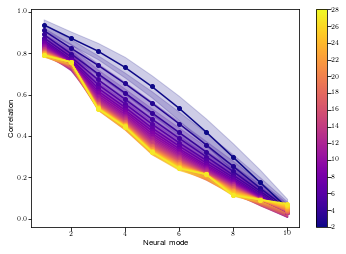

In [32]:
allCCs_targets = subset_CCs[ex_file_idx]

fig, ax = plt.subplots()
colors = utility.get_colors(len(allCCs_targets))
x_ = np.arange(1,defs.n_components+1)
for i,ccs in enumerate(allCCs_targets):
    utility.shaded_errorbar(ax, x_, ccs, color=colors[i], marker = 'o', label =  2+i)
# ax.legend()
ax.set_ylabel('Correlation')
ax.set_xlabel('Neural mode')
info = '_'.join([str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])

cmap = 'plasma'
norm = mpl.colors.Normalize(vmin=2, vmax=28)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_ticks(np.arange(2,29,2))

plt.savefig(FIGPATH / ("RW-cca_subset_targets_"+info+'.pdf'), format= 'pdf', bbox_inches='tight')

### Fig 3C: CCA per neural mode based on number of neurons

In [33]:
def remove_neurons(df, n_removed, signal):
    df_ = df.copy()
    n_neurons = df_[signal].values[0].shape[1]
    size = n_neurons - n_removed
    if size < defs.n_components:
        return False

    mask = params.rng.choice(n_neurons, size, replace = False)
    # print(mask)
    df_[signal] = [arr[:, mask] for arr in df_[signal]]
    
    return df_

n_per_removal = 10
def cca_subsample_neurons(df1, df2, ex_file, redo = False):
    
    # get saved ccs
    info = '_'.join([ex_file[:-4], str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    pathPickle = root / 'random-walk-pickles'/ f'cca_all_subset_neurons_{info}.p'

    if os.path.exists(pathPickle) and not redo:
        #load file
        with open(pathPickle, 'rb') as f:
            CC_corr_subsample = pickle.load(f)
    else: 
        #successively remove neurons
        signal = defs.areas[2] + '_rates'
        n_neurons1 = df1[signal].values[0].shape[1]
        n_neurons2 = df2[signal].values[0].shape[1]
        n_removals = math.floor((min(n_neurons1,n_neurons2)-defs.n_components)/n_per_removal)
        n_iter = 50

        CC_corr_subsample = []
        for i in tqdm(range(n_removals+1)):
            #remove neurons
            n_removed = i*n_per_removal
            CC_corr=[]
            for j in range(n_iter):
                df1_ = remove_neurons(df1, n_removed, signal)
                df2_ = remove_neurons(df2, n_removed, signal)
                if df1_ is False or df2_ is False:
                    continue

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
        
                *_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
                data1 = np.reshape(AllData1[0,:min_trials,:min_time,:], (-1,defs.n_components))
                data2 = np.reshape(AllData2[0,:min_trials,:min_time,:], (-1,defs.n_components))
                CC_corr.append(dt.canoncorr(data1, data2))
            CC_corr_subsample.append(np.array(CC_corr))
        
        with open(pathPickle, 'wb') as f:
            pickle.dump(np.array(CC_corr_subsample), f)   

    
    return CC_corr_subsample


Mihili_RT_VR_2014-01-14.mat


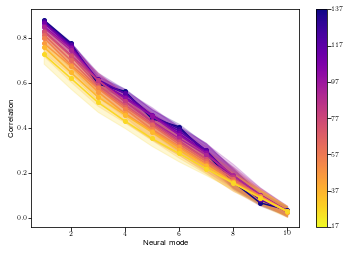

In [39]:
ex_file, df1_, df2_ = paired_dfs[ex_file_idx]
print(ex_file)
n_neurons = df2_['MCx_rates'].values[0].shape[1]
ccs = np.array(cca_subsample_neurons(df1_,df2_, ex_file, redo = False))

fig, ax =plt.subplots()
colors = utility.get_colors(ccs.shape[0])
x_ = np.arange(1,defs.n_components+1)
for i,cc in enumerate(ccs):
    utility.shaded_errorbar(ax, x_, cc.T, color=colors[i], marker = 'o', label = n_neurons - 10*i)
plt.ylabel('Correlation')
plt.xlabel('Neural mode')

cmap = 'plasma_r'
norm = mpl.colors.Normalize(vmin=17, vmax=137)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_ticks(np.arange(17,138,20))

fig.savefig(FIGPATH / 'RW-neuron-drop.pdf', format='pdf', bbox_inches='tight')



### Fig 3D: CCA for permuted conditions

In [40]:
def get_alignments(df1, df2):
    allCCs=[]
    CCsL=[]
    CCsU=[]
    
    subset_target_groups = np.unique(df1.target_group)

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1, df2, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
        
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
        
    # upper bound
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    
    for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    
    return allCCs, CCsL, CCsU

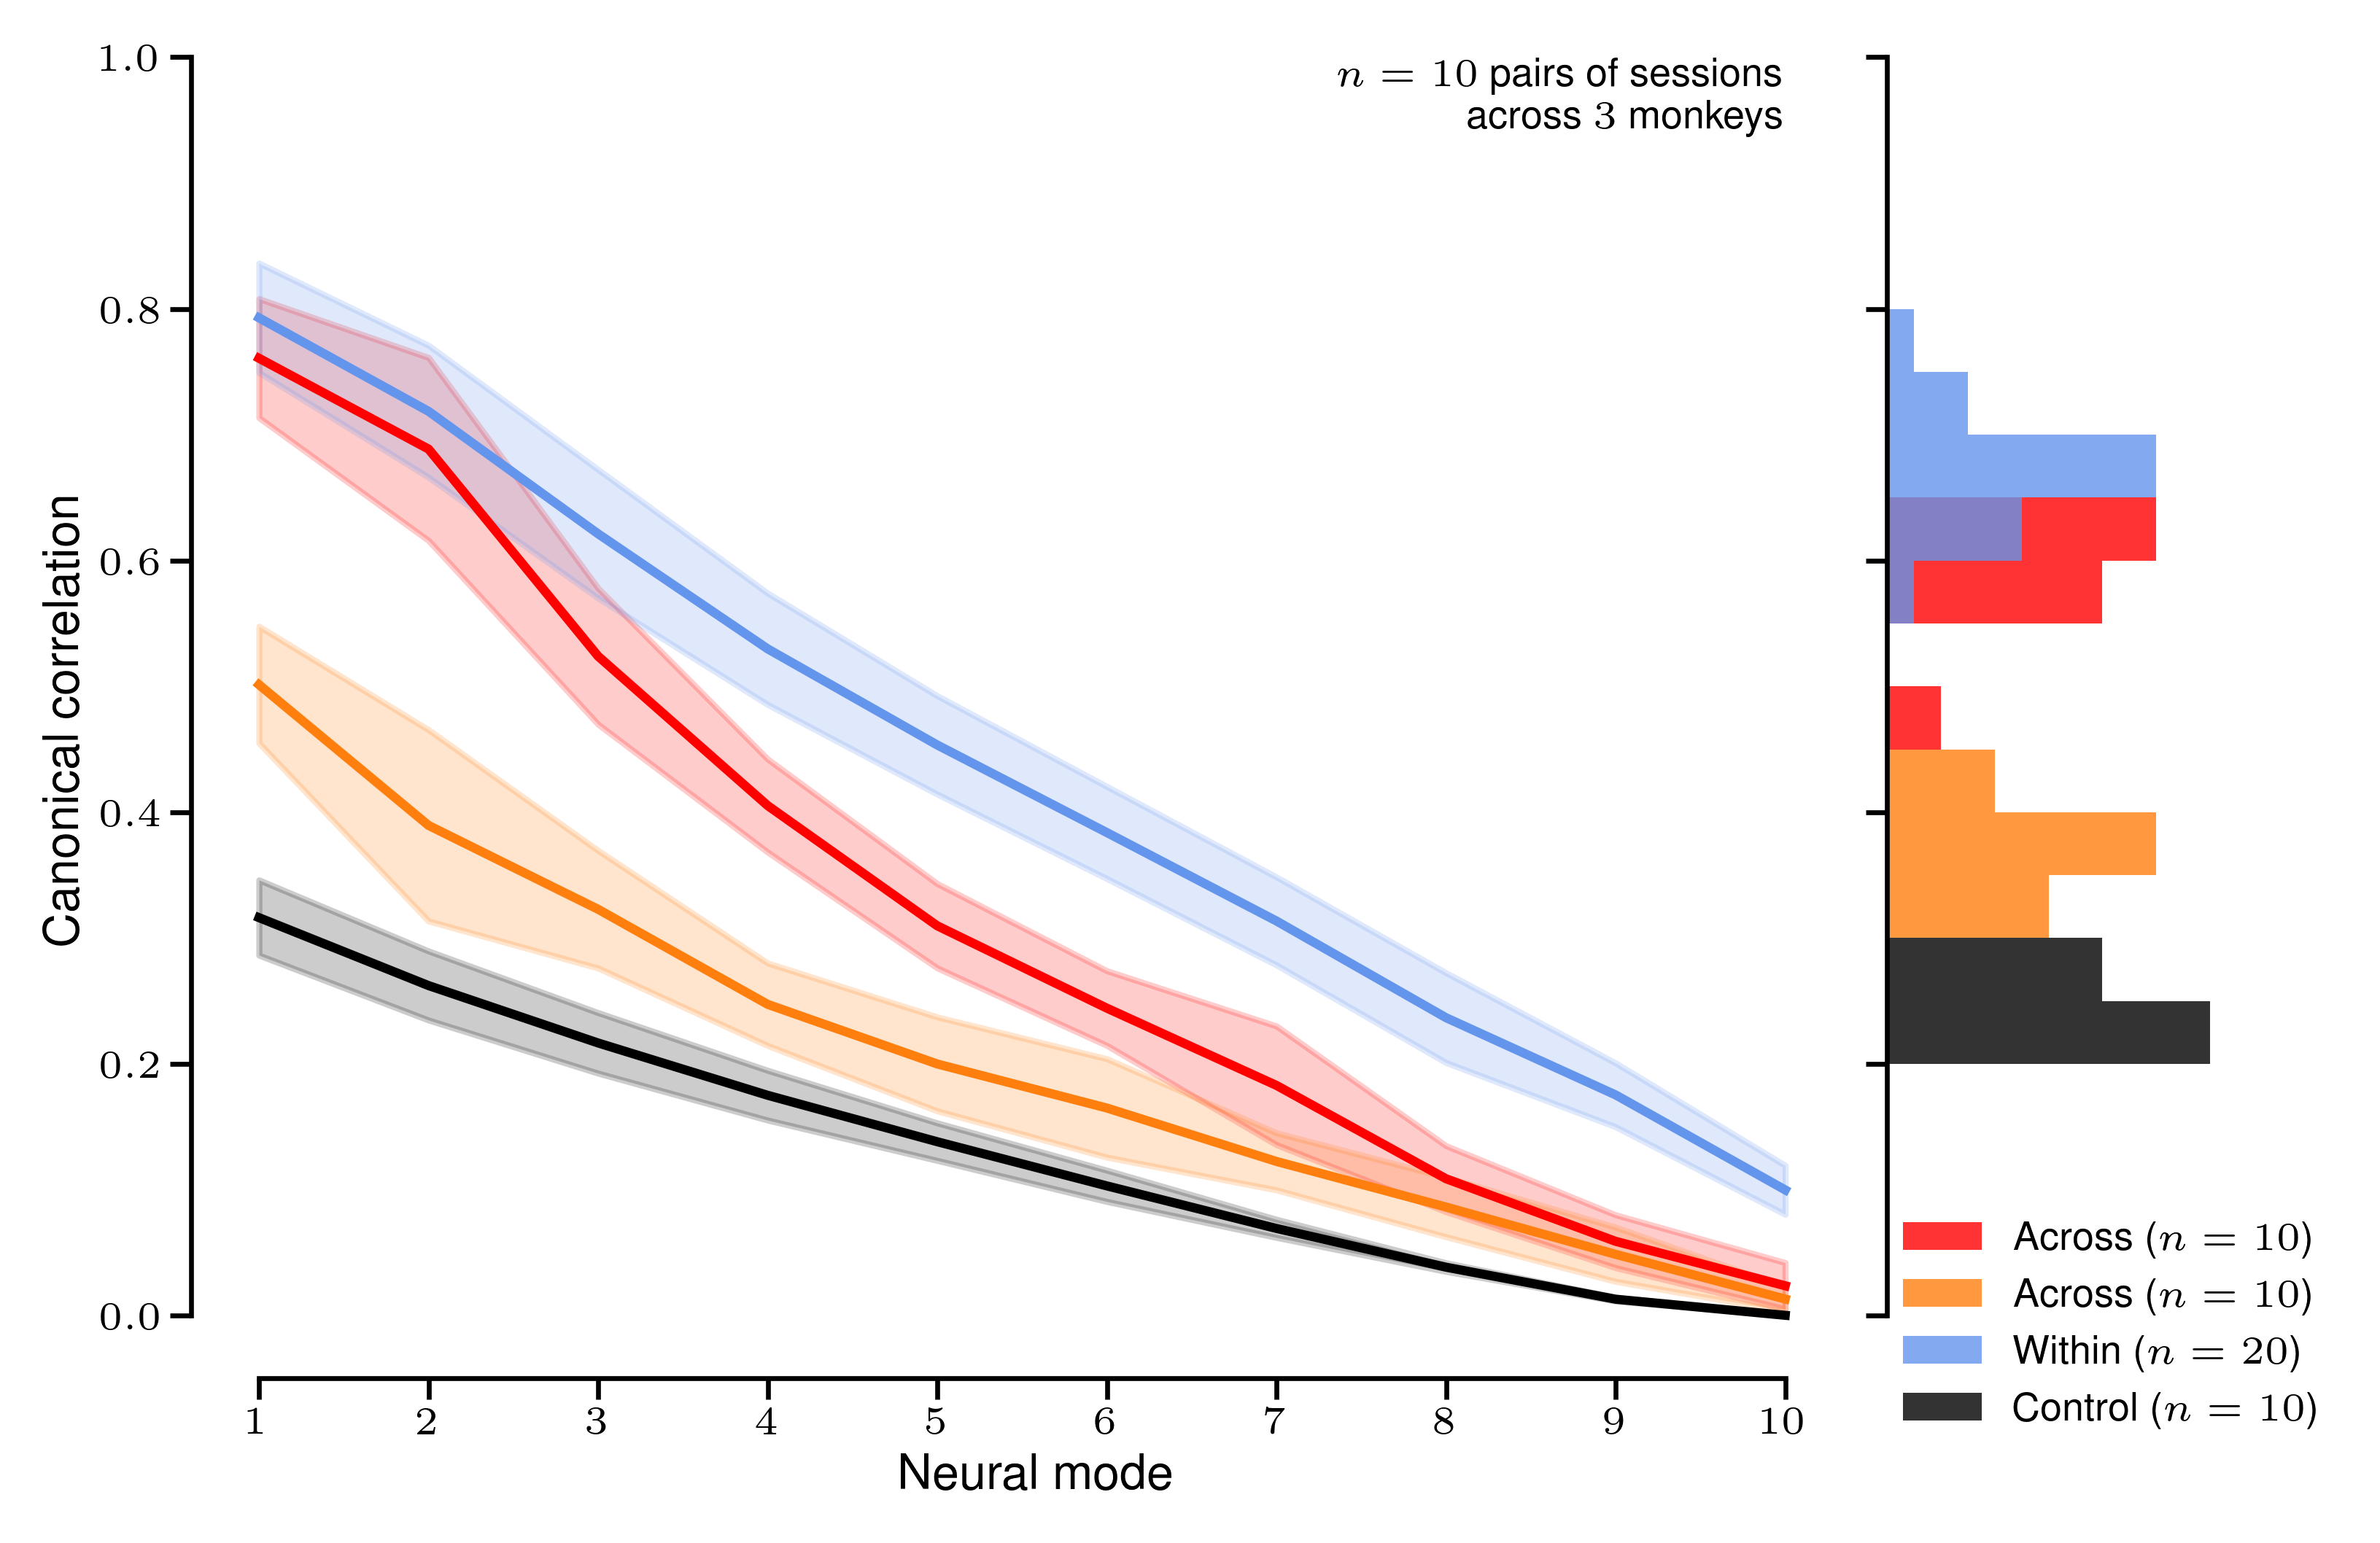

In [41]:
allCCs=[]
CCsL=[]
CCsU=[]
allCCs_sh = []

for ex_file, df1_, df2_ in paired_dfs:
    allCCs_, CCsL_, CCsU_ = get_alignments(df1_, df2_)
    allCCs.extend(allCCs_)
    CCsL.extend(CCsL_)
    CCsU.extend(CCsU_)

    #shuffle conditions
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    shuffled_idx = np.random.permutation(np.arange(AllData1.shape[1])) #permutate targets: lowers
    AllData1[:] = AllData1[:,shuffled_idx,:,:,:]
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs_sh.append(dt.canoncorr(data1, data2))

allCCs = np.array(allCCs).T
allCCs_sh = np.array(allCCs_sh).T
CCsL = np.array(CCsL)
CCsL = np.percentile(CCsL, 1, axis=1).T
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

# plotting
plt.close('all')
set_rc()
fig=plt.figure()
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])

x_ = np.arange(1,defs.n_components+1)
utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC)
utility.shaded_errorbar(ax, x_, allCCs_sh, color='tab:orange')
utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC)
utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC)


ax.set_ylim([-.05,1])
ax.set_xlim([.6, defs.n_components+.6])
ax.set_xlabel('Neural mode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Canonical correlation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds([1,defs.n_components])
ax.spines['left'].set_bounds([0,1])
ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $3$ monkeys',
        ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])


bins = np.arange(0,1,0.05)
ax_hist.xaxis.set_visible(False)
ax_hist.set_facecolor('None')
ax_hist.spines['bottom'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['left'].set_bounds([0,1])
ax_hist.set_ylim([-.05,1])
ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
        color=params.colors.MainCC, alpha=.8, orientation='horizontal')
ax_hist.hist(allCCs_sh[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs_sh.shape[1]}$)', color='tab:orange', alpha=.8, orientation='horizontal')
ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
        color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
        color=params.colors.LowerCC, alpha=.8, orientation='horizontal')

ax_hist.tick_params('y', direction='out')
ax_hist.set_yticklabels([])
ax_hist.legend(loc=(0,-.05))

fig.savefig(FIGPATH / 'RW-CCA.pdf', format='pdf', bbox_inches='tight')